In [1]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import pickle

In [6]:
# 関数を定義
def metropolis_ising(L, T, num_steps, J=1, device="cpu"):
    lattice = np.random.choice([-1, 1], size=(L, L))
    
    for step in range(num_steps):
        i = np.random.randint(L)
        j = np.random.randint(L)
        
        
        # 近傍のスピンの総和を計算（周期境界条件を適用）
        total = lattice[(i + 1) % L, j] + lattice[(i - 1) % L, j] + \
                lattice[i, (j + 1) % L] + lattice[i, (j - 1) % L]
        
        # エネルギー差を計算
        delta_energy = 2 * J * lattice[i, j] * total
        
        if delta_energy < 0 or np.random.rand() < np.exp(-delta_energy / T):
            
            lattice[i, j] *= -1     # スピンを反転させる
            
    # 状況に応じてスピン変数全体を反転
    if np.sum(lattice==1) >= L*L/2:
        lattice = lattice*-1
    else:
        lattice = lattice

    # NumPy配列をPyTorchテンソルに変換し、デバイスに移動
    lattice = torch.tensor(lattice, dtype=torch.float32, device=device)
    
    return lattice

T=1からT=6まで，0.25刻みで配位データを取得

In [48]:
L = 20
num_steps = 100000

# GPUが利用可能であれば、CUDAデバイスを使用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

spin_data = []
temp_data = []

# 一次元データを得る
for T in tqdm(np.arange(0.0, 6.01, 0.25)):
    # T=0はmetropolis_isingには定義されていないのでT=0.01をT=0のデータとする
    if T==0:
        T = 0.01     
    # 各温度で1000個ずつ配位を作成   
    for i in tqdm(range(1000)):
        lattice = metropolis_ising(L, T, num_steps)
        # latticeをGPUに移動してからspin_dataに追加
        spin_data.append(torch.tensor(lattice, dtype=torch.float32, device=device))
        temp_data.append(T)
        
spin_data = torch.stack(spin_data)  # GPU上でテンソルスタック

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\soken\AppData\Local\Temp\ipykernel_12052\1404279372.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_data.append(torch.tensor(lattice, dtype=torch.float32, device=device))
100%|██████████| 25/25 [3:17:53<00:00, 474.95s/it]


In [49]:
# 型を確認
print(type(spin_data))
print(type(temp_data))

<class 'torch.Tensor'>
<class 'list'>


In [50]:
# データサイズの確認
print(torch.Tensor.size(spin_data))
print(len(temp_data))

torch.Size([25000, 20, 20])
25000


tensor([[ 1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1., -1., -1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,

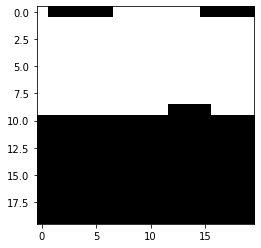

In [52]:
i = 2000
print(spin_data[i])
print(temp_data[i])

# CUDAデバイス上のテンソルをCPU上のNumPy配列に変換
spin_data_cpu = spin_data[i].cpu().numpy()

# CUDAデバイス上のテンソルをCPU上のNumPy配列に変換
plt.imshow(spin_data_cpu, cmap='gray', interpolation='nearest')
plt.show()

In [53]:
# 保存するデータをtupleにまとめる
data_to_save = (spin_data, temp_data)

# データをバイナリ形式で保存
with open('data_L20.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)


In [43]:
spin_data[1]

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]], device='cuda:0')

In [45]:
temp_data[1]

0.01